# Visual Relationship Recognition

## Imports

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
sys.path.append("../Mask_RCNN-master/")
import os
from PIL import Image
from cache import cache

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications import VGG16

from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
tf.__version__

'1.15.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data

### [Open Images Dataset V5](https://storage.googleapis.com/openimages/web/challenge.html)


Image Net compressed data (52Gb): [https://drive.google.com/uc?id=10yVowvmFjMkY21-DGF2pej_Lbecfqou7](https://drive.google.com/uc?id=10yVowvmFjMkY21-DGF2pej_Lbecfqou7)  ([Info](https://www.kaggle.com/c/landmark-recognition-2019/discussion/91770))


In [6]:
IMAGE_DIR = r"D:\data\train-256\train"
DATA_OUTPUT_DIR = r"D:\data\VRNet"

In [7]:
DEPTH = 9
LAYER_TYPE = 'LSTM' #'GRU' #  

***

***

In [8]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path).convert('RGB')

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

## Transfer

In [9]:
from tensorflow.keras.applications import \
    VGG16, VGG19, InceptionV3, ResNet50, ResNet101, NASNetLarge, MobileNetV2

image_model = MobileNetV2(include_top=True, weights='imagenet')
IMAGE_MODEL_NAME = image_model.name

W0330 19:42:07.034004 15920 deprecation.py:506] From c:\pphiles\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


https://github.com/matterport/Mask_RCNN/releases

In [10]:
image_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
# transfer_layer = image_model.get_layer('fc2')
transfer_layer = image_model.layers[-2]

In [12]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [13]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [14]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

1280

***

#### Process All Images

We now make functions for processing all images in the data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing the progress.

In [15]:
def load_image_wboxes(image_path, boxes, size=None):
    img_size = size
    # Path for the image-file.
#     image_path = os.path.join(IMAGE_DIR_REL, (iid + '.jpg'))
    
    # resize crop resize bad?
    img = Image.open(image_path).convert('RGB')
    img = img.resize(size=img_size, resample=Image.LANCZOS)
    
    imgs = []
    for box in boxes:
        boxd = img_size[0]*box[0], img_size[0]*box[1], img_size[1]*box[2], img_size[1]*box[3]
#         boxd = tuple([int(x) for x in boxd])
        # xx yy => xy, xy
        boxd = boxd[0], boxd[2], boxd[1], boxd[3]

        imgc = img.crop(boxd)
        imgc = imgc.resize(size=img_size, resample=Image.LANCZOS)

        # Convert image to numpy array.
        imgc = np.array(img)

        # Scale image-pixels so they fall between 0.0 and 1.0
        imgc = imgc / 255.0

        # Convert 2-dim gray-scale array to 3-dim RGB array.
        if (len(imgc.shape) == 2):
            imgc = np.repeat(imgc[:, :, np.newaxis], 3, axis=2)

        imgs.append(imgc)
    return imgs

In [16]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%} {1}/{2}".format(pct_complete, count, max_count)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [17]:
def process_images_wboxes(data_dir, filenames, boxes_listlist, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    reindexer = [(i, j) for i in range(len(boxes_listlist)) 
                for j in range(len(boxes_listlist[i]))]
    
    boxes_list_flat = [box 
                       for box_list in boxes_listlist
                       for box in box_list]
        
    # Number of images to process.
    num_images = len(boxes_list_flat)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # cache image for multiple boxes
        prev_imx = -1
        prev_boxes = None
        # Load all the images in the batch.
        for i, filename in enumerate(boxes_list_flat[start_index:end_index]):
            # image index, box index
            imx, bxx = reindexer[start_index + i]
            
            if imx == prev_imx:
                image_batch[i] = prev_boxes[bxx]
            else: 
                # Path for the image-file.
                path = os.path.join(data_dir, filenames[imx])
                # Load and resize the image.
                # This returns the image as a numpy-array.
                prev_boxes = load_image_wboxes(path, boxes_listlist[imx], size=img_size)
                
                prev_imx = imx
                # Save the image for later use.
                image_batch[i] = prev_boxes[bxx]

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    
    #import pickle
    #removal_list_file = "to_remove.pkl"
    #with open(removal_list_file, 'wb') as f:
    #    pickle.dump(removal_list, f)
    
    # Print newline.
    print()

    return transfer_values

In [18]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
        
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            #try: 
            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img
            #except: 
            # print(f"\nFaulty image: {i, filename}")
            # removal_list.append(filename)
            # os.remove(filename)
            # faulty_imgs.append(filename)

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    
    #import pickle
    #removal_list_file = "to_remove.pkl"
    #with open(removal_list_file, 'wb') as f:
    #    pickle.dump(removal_list, f)
    
    # Print newline.
    print()

    return transfer_values

In [19]:
def process_images_train_wboxes(filenames_array, boxes_array, output_fn, batch_size=32):
    print("Processing {0} images in training-set ...".format(len(filenames_array)))
    print("Total {0} boxes in all the images ...".format(sum([len(b) for b in boxes_array])))

    # Path for the cache-file.
    cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"transfer_values_wboxes_{output_fn}.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images_wboxes,
                            data_dir=IMAGE_DIR,
                            boxes_listlist=boxes_array,
                            filenames=filenames_array, 
                            batch_size=batch_size)

    return transfer_values

In [20]:
def process_images_train(filenames_array, output_fn):
    print("Processing {0} images in training-set ...".format(len(filenames_array)))

    # Path for the cache-file.
    cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"transfer_values_{output_fn}.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=IMAGE_DIR,
                            filenames=filenames_array)

    return transfer_values

***

## Augmentation

# Tokenization

***

***

In [21]:
IMAGE_DIR_REL = r"D:\data\VRNet\imagenet_rel_subset"

In [22]:
all_relationships_file = r"D:\data\open-images-2019-visual-relationship\challenge-2019-train-vrd.csv"
all_relationships = pd.read_csv(all_relationships_file)
all_relationships.describe()

XMin1          XMax1          YMin1          YMax1  \
count  374768.000000  374768.000000  374768.000000  374768.000000   
mean        0.373899       0.624713       0.426304       0.785764   
std         0.267712       0.267785       0.219537       0.206131   
min         0.000000       0.002930       0.000000       0.013542   
25%         0.136875       0.409944       0.262500       0.642222   
50%         0.355000       0.642500       0.442653       0.830833   
75%         0.588750       0.861875       0.589286       0.983333   
max         0.999375       2.055000       0.996248       1.196667   

               XMin2          XMax2          YMin2          YMax2  
count  374768.000000  374768.000000  374768.000000  374768.000000  
mean        0.333565       0.666269       0.500565       0.807825  
std         0.264643       0.265483       0.197521       0.203616  
min         0.000000       0.002930       0.000000       0.013542  
25%         0.097000       0.462313       0.388980       0.670732  
50%         0.295625       0.704102       0.522222       0.872045  
75%         0.534729       0.905582       0.636023       0.995028  
max         0.999375       2.055000       0.996248       1.196667

In [23]:
rel_definition_file = r"D:\data\open-images-2019-visual-relationship\challenge-2019-relationship-triplets.csv"
rel_definition = pd.read_csv(rel_definition_file)
rel_definition.describe()

LabelName1 LabelName2 RelationshipLabel
count         329        329               329
unique         32         58                10
top      /m/04yx4  /m/04bcr3             holds
freq           63         18               108

In [24]:
rel_counts = all_relationships.ImageID.value_counts()
rel_counts

ab4f5a8a2f533316    474
bca2e0ee12378c67    168
640a5f71e5aed9e8    145
27bb93c740ae1fe3    145
05b0aefc92880a6c    138
                   ... 
03dbc2cf4514b665      1
db87a56a4c8e43a2      1
dc4d9a20c68c6a86      1
00d8efd5fd1d8847      1
6702a54280bf2c32      1
Name: ImageID, Length: 100522, dtype: int64

## Remove is relations:----

In [25]:
# Do not use 'is' relationships
all_relationships_non_is = all_relationships[all_relationships.RelationshipLabel != "is"]
len(all_relationships_non_is)

180626

In [26]:
images_w_relationships = all_relationships_non_is.ImageID.unique()
len(images_w_relationships)

57187

In [27]:
images_w_relationships_paths = [os.path.join(IMAGE_DIR_REL, (f + '.jpg')) for f in images_w_relationships]
len(images_w_relationships_paths)

57187

In [28]:
imageIDs_trainz = images_w_relationships

In [29]:
# Some images don't work
# imageIDs_trainz = imageIDs_trainz[imageIDs_trainz!=("5f07cc69123be854")]

In [30]:
filenames_trainz = [os.path.join(IMAGE_DIR_REL, (f + '.jpg')) for f in imageIDs_trainz]
len(filenames_trainz)

57187

***

***

## Transfer values (Image Embeddings)

In [27]:
%%time
transfer_values_train = process_images_train(filenames_trainz, f"{image_model.name}")
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 57187 images in training-set ...
- Data loaded from cache-file: D:\data\VRNet\transfer_values_mobilenetv2_1.00_224.pkl
dtype: float16
shape: (57187, 1280)
Wall time: 210 ms


In [31]:
# Get training relationships
trainz_relationships = all_relationships_non_is[all_relationships_non_is.ImageID.isin(imageIDs_trainz)]
len(trainz_relationships)

180626

***

# TOkenizerr

### class dictionary

In [32]:
import csv
class_dict = {}
reader = csv.reader(open(r"D:\data\open-images-2019-visual-relationship\challenge-2019-classes-vrd.csv"))
for row in reader:
    k, v = row
    class_dict[k] = v.replace(' ', '').replace('(', '').replace(')', '').lower()

reader = csv.reader(open( r"D:\data\open-images-2019-visual-relationship\challenge-2019-attributes-description.csv"))
for row in reader:
    k, v = row
    class_dict[k] = v.replace(' ', '').replace('(', '').replace(')', '').lower()

In [33]:
trainz_relationships['LabelClass1'] = trainz_relationships.LabelName1.apply(lambda x: class_dict[x])
trainz_relationships['LabelClass2'] = trainz_relationships.LabelName2.apply(lambda x: class_dict[x])

***

In [34]:
%%time
# BBox
trainz_relationships['XMin'] = trainz_relationships.apply(lambda x: min(x['XMin1'], x['XMin2']), axis=1)
trainz_relationships['XMax'] = trainz_relationships.apply(lambda x: max(x['XMax1'], x['XMax2']), axis=1)
trainz_relationships['YMin'] = trainz_relationships.apply(lambda x: min(x['YMin1'], x['YMin2']), axis=1)
trainz_relationships['YMax'] = trainz_relationships.apply(lambda x: max(x['YMax1'], x['YMax2']), axis=1)

Wall time: 16.3 s


In [35]:
trainz_relationships.head()

ImageID  LabelName1 LabelName2     XMin1     XMax1     YMin1  \
3  4b6a08cc110d7275   /m/01mzpv  /m/01y9k5  0.171250  0.255625  0.557500   
4  0144cfbb726f4c72   /m/01mzpv  /m/04bcr3  0.855000  0.950000  0.561667   
5  03b5764a5c600aa4    /m/04yx4   /m/0199g  0.114068  0.205323  0.334375   
6  d18adac47a838d35  /m/03bt1vf  /m/04bcr3  0.531875  0.597500  0.054409   
7  487e3f4413229d30    /m/04yx4  /m/04bcr3  0.281250  0.706875  0.103578   

      YMax1    XMin2     XMax2     YMin2     YMax2 RelationshipLabel  \
3  0.749167  0.20750  0.683125  0.611667  0.999167                at   
4  0.609167  0.82875  0.999375  0.568333  0.673333                at   
5  0.453750  0.13308  0.200570  0.383750  0.465625                on   
6  0.196060  0.00000  0.999375  0.147280  0.447467                at   
7  0.780603  0.00000  0.999375  0.731638  0.999058                at   

  LabelClass1 LabelClass2      XMin      XMax      YMin      YMax  
3       chair        desk  0.171250  0.683125  0.557500  0.999167  
4       chair       table  0.828750  0.999375  0.561667  0.673333  
5         man     bicycle  0.114068  0.205323  0.334375  0.465625  
6       woman       table  0.000000  0.999375  0.054409  0.447467  
7         man       table  0.000000  0.999375  0.103578  0.999058

***

In [36]:
def get_relationship_triplet_list():

    trainz_relationship_list = []
    i = 0
    for iid in imageIDs_trainz:
        print_progress(i, len(imageIDs_trainz))
        trainz_relationship_list.append(trainz_relationships.loc[trainz_relationships.ImageID == iid, \
                                                                 ["LabelClass1", "LabelClass2", "RelationshipLabel"]].values)
        i = i+1
    return trainz_relationship_list

In [37]:
%%time
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              "trainz_relationship_list.pkl")

trainz_relationship_list = cache(cache_path=cache_path,
                        fn=get_relationship_triplet_list)

len(trainz_relationship_list)

- Data loaded from cache-file: D:\data\VRNet\trainz_relationship_list.pkl
Wall time: 347 ms


57187

***

In [38]:
def get_bbox_list():

    trainz_bbox_list = []
    i = 0
    for iid in imageIDs_trainz:
        print_progress(i, len(imageIDs_trainz))
        trainz_bbox_list.append(trainz_relationships.loc[trainz_relationships.ImageID == iid, \
                                                                 ["XMin", "XMax", "YMin", "YMax"]].values)
        i = i+1
    return trainz_bbox_list

In [39]:
%%time
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              "trainz_bbox_list.pkl")

trainz_bbox_list = cache(cache_path=cache_path,
                        fn=get_bbox_list)

len(trainz_bbox_list)

- Data loaded from cache-file: D:\data\VRNet\trainz_bbox_list.pkl
Wall time: 769 ms


57187

In [39]:
%%time
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              "trainz_bbox_list.pkl")

trainz_bbox_list = cache(cache_path=cache_path,
                        fn=get_bbox_list)

len(trainz_bbox_list)

- Progress: 100.0% 57186/57187- Data saved to cache-file: D:\data\VRNet\trainz_bbox_list.pkl
Wall time: 18min 50s


57187

***

## Boxes

In [40]:
def parse_boxes(boxes): 
    return np.asarray([[eval(coord) 
                        for coord in box.strip().strip('[').strip(']').split()] 
                       for box in boxes.replace(']-', '],')[1:-1].split(',')])

In [41]:
dbboxess = [parse_boxes(line) for line in open(r"D:\Downloads\models-master\research\object_detection\liny.txt", 'r')]

In [42]:
%%time
tran_dbboxess = []
zero = []
# (ymin, xmin, ymax, xmax) => x1, x2, y1, y2
for i, dbboxes in enumerate(dbboxess): 
    boxes = []
    for b in dbboxes: 
        try: 
            boxes.append((b[1], b[3], b[0], b[2]))
        except:
            # zero detected boxes
            zero.append(i)
    tran_dbboxess.append(boxes)
        
# tran_dbboxess xxyy**
rel_dbboxess = []
for dbboxes in tran_dbboxess:
    rel_dbboxes = []
    for box1 in dbboxes:
        for box2 in dbboxes:
            #if len(bbs1)!=0:
            if str(box1) != str(box2):
                re_box = min(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), max(box1[3], box2[3])
                rel_dbboxes.append(re_box)
    rel_dbboxess.append(rel_dbboxes)

Wall time: 32.8 s


### Match detected to real boxes

In [43]:
def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[2], boxB[2])
    xB = min(boxA[1], boxB[1])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
    boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [44]:
IOU_THRESHOLD = .89

In [45]:
%%time
trainz_matched_bbox_list = []
print(f"Total true boxes: {len([b for bs in trainz_bbox_list for b in bs])}")
for i, bboxs in enumerate(trainz_bbox_list):
    trainz_matched_bbox = []
    for bbox in bboxs:
        matches = {} #
        for dbox in set(rel_dbboxess[i]):
            matches[str(dbox)] = compute_iou(dbox, bbox)
        matches[str([0,1,0,1])] = -1
        topm = max(matches, key=matches.get)
        if matches[topm] >= IOU_THRESHOLD:
            trainz_matched_bbox.append(eval(topm))
        else:
            trainz_matched_bbox.append([0,1,0,1])
    trainz_matched_bbox_list.append(np.asarray(trainz_matched_bbox))
len([b for bs in trainz_matched_bbox_list for b in bs])

Total true boxes: 180626
Wall time: 2min 43s


180626

***

In [46]:
def show_image(iid, boxes=[], rels=None):
    # Path for the image-file.
    image_path = os.path.join(IMAGE_DIR_REL, (iid + '.jpg'))
    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    plt.rcParams["figure.figsize"] = (18,6)
    import matplotlib.patches as patches
    from matplotlib.offsetbox import AnchoredText
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # xx, yy
    if len(boxes)!=0:
        for i, box in enumerate(boxes):
            boxd = img_size[0]*box[0], img_size[0]*box[1], img_size[1]*box[2], img_size[1]*box[3]
#             print(boxd)
            x1, x2, y1, y2 = boxd
            if ((x2-x1),(y2-y1)) == img_size:
                print("full image")
            col = np.random.rand(3,)
            rect = patches.Rectangle((x1, y1),(x2-x1),(y2-y1),linewidth=1,ec=col,fc='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            if rels:
                ax.text(x1+3, y1+8, rels[i], bbox=dict(ec=col, fc=col, linewidth=-1, alpha=0.4))
    # Plot the image.
    plt.show()

## Send back up

In [47]:
%%time
transfer_values_train = process_images_train_wboxes(filenames_trainz, trainz_matched_bbox_list, f"{image_model.name}")
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 57187 images in training-set ...
Total 180626 boxes in all the images ...
- Data loaded from cache-file: D:\data\VRNet\transfer_values_wboxes_mobilenetv2_1.00_224.pkl
dtype: float16
shape: (180626, 1280)
Wall time: 28.8 s


In [59]:
%%time
transfer_values_train = process_images_train_wboxes(filenames_trainz, trainz_matched_bbox_list, f"{image_model.name}")
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 57187 images in training-set ...
Total 180626 boxes in all the images ...
- Progress: 100.0% 180608/180626
- Data saved to cache-file: D:\data\VRNet\transfer_values_wboxes_mobilenetv2_1.00_224.pkl
dtype: float16
shape: (180626, 1280)
Wall time: 1h 23min 33s


***

## Train Test Split

In [48]:
len([b for bs in trainz_relationship_list for b in bs])

180626

In [49]:
len([b for bs in trainz_bbox_list for b in bs])

180626

In [50]:
len([b for bs in trainz_matched_bbox_list for b in bs])

180626

In [51]:
len(transfer_values_train)

180626

In [52]:
b = [r for r in range(20)]
n_test = 5
print(f"test: {b[-n_test:]}")
print(f"trai: {b[:-n_test]}")

test: [15, 16, 17, 18, 19]
trai: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [53]:
# Split train and validation
n_test = 5700

testz_relationship_list = trainz_relationship_list[-n_test:]
trainz_relationship_list = trainz_relationship_list[:-n_test]

testz_bbox_list = trainz_bbox_list[-n_test:]
trainz_bbox_list = trainz_bbox_list[:-n_test]

testz_matched_bbox_list = trainz_matched_bbox_list[-n_test:]
trainz_matched_bbox_list = trainz_matched_bbox_list[:-n_test]

len(trainz_relationship_list), len(testz_relationship_list)

(51487, 5700)

In [54]:
# reroll?
n_boxes_test = len([b for bs in testz_matched_bbox_list for b in bs])

transfer_values_test = transfer_values_train[-n_boxes_test:]
transfer_values_train = transfer_values_train[:-n_boxes_test]

len(transfer_values_train), len(transfer_values_test)

(174106, 6520)

In [55]:
len([b for bs in trainz_bbox_list for b in bs]) , len([b for bs in testz_bbox_list for b in bs])

(174106, 6520)

In [56]:
len(transfer_values_train)

174106

In [57]:
trainz_relationship_list[7], trainz_bbox_list[7], trainz_matched_bbox_list[7]

(array([['man', 'table', 'at'],
        ['man', 'table', 'at'],
        ['man', 'table', 'at']], dtype=object),
 array([[0.        , 0.9710938 , 0.47916666, 0.99895835],
        [0.        , 0.86640626, 0.41875   , 0.99895835],
        [0.        , 0.86640626, 0.1375    , 0.99895835]]),
 array([[0.00887012, 0.96708417, 0.4169166 , 0.98196816],
        [0.00887012, 0.96708417, 0.4169166 , 0.98196816],
        [0.00887012, 0.7518287 , 0.14517802, 0.9252697 ]]))

***

***

***

### Start marker

In [58]:
mark_start = 'ss '

In [59]:
trainz_relationship_list_joined = [[' '.join(rel) for rel in relations]
                                  for relations in trainz_relationship_list]

In [60]:
trainz_relationship_list_joined_s = [[mark_start + relation 
                        for relation in relations_list]
                        for relations_list in trainz_relationship_list_joined]

In [61]:
testz_relationship_list_joined = [[' '.join(rel) for rel in relations]
                                  for relations in testz_relationship_list]

In [62]:
testz_relationship_list_joined_s = [[mark_start + relation 
                        for relation in relations_list]
                        for relations_list in testz_relationship_list_joined]

In [63]:
trainz_relationship_list_joined_s[3]

['ss woman table at',
 'ss man table at',
 'ss man table at',
 'ss woman table at',
 'ss man table at',
 'ss man table at',
 'ss man table at',
 'ss woman table at',
 'ss man table at',
 'ss man table at']

trainz_relationship_list_joined = [list(set([' '.join(rel) for rel in relations])) 
                                   for relations in trainz_relationship_list]

In [64]:
def flatten(relations_listlist):
    relations_list = [relation
                     for relations_list in relations_listlist
                     for relation in relations_list]
    
    return relations_list

In [65]:
relations_train_flat = flatten(trainz_relationship_list_joined_s+testz_relationship_list_joined_s)

In [66]:
trainz_relationship_list_joined[0]

['chair desk at',
 'chair table at',
 'chair table at',
 'chair desk at',
 'man desk at',
 'man table at',
 'chair desk at',
 'chair desk at',
 'chair table at',
 'man table at',
 'chair table at',
 'man table at',
 'chair desk at',
 'man desk at',
 'chair table at',
 'chair table at',
 'man chair on',
 'man table at',
 'chair desk at',
 'chair table at',
 'chair table at',
 'chair desk at',
 'man table at',
 'chair table at',
 'chair table at',
 'man chair on',
 'chair table at',
 'chair desk at',
 'chair table at',
 'chair table at',
 'man desk at',
 'chair table at',
 'chair desk at',
 'man desk at',
 'man chair on',
 'chair table at',
 'man desk at',
 'chair table at',
 'man table at',
 'chair desk at',
 'chair table at',
 'chair desk at',
 'chair desk at',
 'chair table at',
 'chair table at',
 'chair desk at',
 'chair desk at',
 'chair desk at',
 'chair table at',
 'chair desk at',
 'chair desk at']

In [67]:
relations_train_flat[0]

'ss chair desk at'

In [68]:
len(trainz_relationship_list_joined), len(relations_train_flat)

(51487, 180626)

relations_train_flat_num = [dicto[word] for relation in relations_train_flat for word in relation.split(' ')]

In [69]:
len(np.unique(relations_train_flat))

287

In [70]:
num_words = len(np.unique([(relation)
     for relations_list in trainz_relationship_list
     for relation in relations_list]))
num_words

66

In [71]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [72]:
%%time
tokenizer = TokenizerWrap(texts=relations_train_flat,
                          num_words=num_words)

Wall time: 2.37 s


In [73]:
tokenizer.word_index

{'ss': 1,
 'at': 2,
 'table': 3,
 'man': 4,
 'chair': 5,
 'woman': 6,
 'on': 7,
 'holds': 8,
 'guitar': 9,
 'desk': 10,
 'girl': 11,
 'plays': 12,
 'microphone': 13,
 'coffeetable': 14,
 'wineglass': 15,
 'bicycle': 16,
 'interacts': 17,
 'with': 18,
 'boy': 19,
 'drum': 20,
 'bottle': 21,
 'inside': 22,
 'of': 23,
 'car': 24,
 'dog': 25,
 'horse': 26,
 'camera': 27,
 'beer': 28,
 'motorcycle': 29,
 'violin': 30,
 'football': 31,
 'handbag': 32,
 'coffeecup': 33,
 'bench': 34,
 'wears': 35,
 'mobilephone': 36,
 'bed': 37,
 'hits': 38,
 'cat': 39,
 'tennisracket': 40,
 'sofabed': 41,
 'mug': 42,
 'surfboard': 43,
 'fork': 44,
 'tabletennisracket': 45,
 'flute': 46,
 'backpack': 47,
 'racket': 48,
 'spoon': 49,
 'piano': 50,
 'elephant': 51,
 'ski': 52,
 'rugbyball': 53,
 'suitcase': 54,
 'van': 55,
 'snake': 56,
 'chopsticks': 57,
 'under': 58,
 'monkey': 59,
 'snowboard': 60,
 'taxi': 61,
 'tennisball': 62,
 'dolphin': 63,
 'knife': 64,
 'hamster': 65,
 'pretzel': 66,
 'briefcase': 67,

In [74]:
%%time
tokens_train = tokenizer.captions_to_tokens(trainz_relationship_list_joined_s)

Wall time: 2.4 s


In [75]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

1

In [76]:
tokenizer.word_index["man"]

4

In [77]:
tokens_train[3]

[[1, 6, 3, 2],
 [1, 4, 3, 2],
 [1, 4, 3, 2],
 [1, 6, 3, 2],
 [1, 4, 3, 2],
 [1, 4, 3, 2],
 [1, 4, 3, 2],
 [1, 6, 3, 2],
 [1, 4, 3, 2],
 [1, 4, 3, 2]]

In [78]:
trainz_relationship_list_joined[3]

['woman table at',
 'man table at',
 'man table at',
 'woman table at',
 'man table at',
 'man table at',
 'man table at',
 'woman table at',
 'man table at',
 'man table at']

In [79]:
# number of relationships per image
count = [len(coun) for coun in trainz_relationship_list_joined]
dic = {}
for num in set(count):
    dic[num] = count.count(num)
dic

{1: 18219,
 2: 12894,
 3: 5314,
 4: 4470,
 5: 2424,
 6: 1973,
 7: 1286,
 8: 1015,
 9: 740,
 10: 619,
 11: 483,
 12: 348,
 13: 239,
 14: 211,
 15: 191,
 16: 159,
 17: 127,
 18: 91,
 19: 100,
 20: 78,
 21: 69,
 22: 54,
 23: 43,
 24: 45,
 25: 35,
 26: 25,
 27: 36,
 28: 26,
 29: 27,
 30: 20,
 31: 16,
 32: 14,
 33: 8,
 34: 13,
 35: 10,
 36: 9,
 37: 9,
 38: 3,
 39: 7,
 40: 5,
 41: 1,
 42: 1,
 44: 6,
 45: 3,
 46: 4,
 47: 2,
 48: 3,
 49: 2,
 50: 1,
 51: 2,
 52: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 67: 1}

In [80]:
# unique relationships
len(np.unique(trainz_relationship_list_joined))

9470

In [81]:
# unique classes
len(np.unique([r for rs in trainz_relationship_list for r in rs]))

66

***

***

***

***

correct bbxs from img model

***

***

## Data Generator

In [82]:
tokens_train_flat = [t for ts in tokens_train for t in ts]
len(tokens_train_flat)

174106

In [83]:
num_images_train = len(transfer_values_train)
num_images_train

174106

In [84]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

#         # Get a random index for a token-sequence.
#         j = np.random.choice(len(tokens_train[i]))

#         # Get the j'th token-sequence for image i.
#         tokens = tokens_train[i][j]
        tokens = tokens_train_flat[i]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [85]:
get_random_caption_tokens([2])

[[1, 5, 3, 2]]

In [86]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        # TODO
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [87]:
batch_size = 256

In [88]:
generator = batch_generator(batch_size=batch_size)

In [89]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [90]:
batch_x['transfer_values_input'][0]

array([0.1375  , 0.00946 , 0.002344, ..., 0.3035  , 0.3599  , 1.258   ],
      dtype=float16)

In [91]:
batch_x['decoder_input'][0]

array([ 1, 15,  3,  7])

In [92]:
batch_y['decoder_output'][0]

array([15,  3,  7,  0])

In [93]:
num_captions_train = [len(captions) for captions in trainz_relationship_list_joined_s]

In [94]:
total_num_captions_train = np.sum(num_captions_train)
total_num_captions_train

174106

In [95]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

680

***

***

# Network

In [96]:
state_size = 512

In [97]:
embedding_size = 128

In [98]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [99]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [100]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [101]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

W0330 20:23:01.037835 15920 deprecation.py:506] From c:\pphiles\python37\lib\site-packages\tensorflow_core\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [102]:
if LAYER_TYPE == 'GRU':
    if DEPTH >= 3:
        decoder_gru1 = GRU(state_size, name='decoder_gru1',
                           return_sequences=True)
        decoder_gru2 = GRU(state_size, name='decoder_gru2',
                           return_sequences=True)
        decoder_gru3 = GRU(state_size, name='decoder_gru3',
                           return_sequences=True)
    if DEPTH >= 6:
        decoder_gru4 = GRU(state_size, name='decoder_gru4',
                           return_sequences=True)
        decoder_gru5 = GRU(state_size, name='decoder_gru5',
                           return_sequences=True)
        decoder_gru6 = GRU(state_size, name='decoder_gru6',
                           return_sequences=True)
    if DEPTH >= 9:
        decoder_gru7 = GRU(state_size, name='decoder_gru7',
                           return_sequences=True)
        decoder_gru8 = GRU(state_size, name='decoder_gru8',
                           return_sequences=True)
        decoder_gru9 = GRU(state_size, name='decoder_gru9',
                           return_sequences=True)

if LAYER_TYPE == 'LSTM':
    if DEPTH >= 3:
        decoder_gru1 = LSTM(state_size, name='decoder_lstm1',
                           return_sequences=True)
        decoder_gru2 = LSTM(state_size, name='decoder_lstm2',
                           return_sequences=True)
        decoder_gru3 = LSTM(state_size, name='decoder_lstm3',
                           return_sequences=True)
    if DEPTH >= 6:
        decoder_gru4 = LSTM(state_size, name='decoder_lstm4',
                           return_sequences=True)
        decoder_gru5 = LSTM(state_size, name='decoder_lstm5',
                           return_sequences=True)
        decoder_gru6 = LSTM(state_size, name='decoder_lstm6',
                           return_sequences=True)
    if DEPTH >= 9:
        decoder_gru7 = LSTM(state_size, name='decoder_lstm7',
                           return_sequences=True)
        decoder_gru8 = LSTM(state_size, name='decoder_lstm8',
                           return_sequences=True)
        decoder_gru9 = LSTM(state_size, name='decoder_lstm9',
                           return_sequences=True)

In [103]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

***

In [104]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    if DEPTH >= 3:
        net = decoder_gru1(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))
        net = decoder_gru2(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))
        net = decoder_gru3(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))
    if DEPTH >= 6:
        net = decoder_gru4(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))
        net = decoder_gru5(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))
        net = decoder_gru6(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))
    if DEPTH >= 9:
        net = decoder_gru7(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))
        net = decoder_gru8(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))
        net = decoder_gru9(net, initial_state=(initial_state if LAYER_TYPE=='GRU' else [initial_state, initial_state]))

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [105]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [106]:
# decoder_model.compile(optimizer=optimizer,
#                       loss='sparse_categorical_crossentropy')

In [107]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

***

In [108]:
optimizer = RMSprop(lr=1e-3) # or Adam

In [109]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [110]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [111]:
models_path = r'D:\Documents\ITIS\Research\nnet'

In [112]:
path_checkpoint = f'{models_path}/vnet_bb_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)
path_checkpoint

'D:\\Documents\\ITIS\\Research\\nnet/vnet_bb_mobilenetv2_1.00_224_9_lstm_checkpoint.keras'

In [113]:
callback_tensorboard = TensorBoard(log_dir=f'{models_path}/vnet_bb_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [114]:
callbacks = [callback_checkpoint, callback_tensorboard]

***

***

In [115]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [493]:
%%time
decoder_model.fit(generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=30,
                  callbacks=callbacks)

Epoch 1/30
679/680 [============================>.] - ETA: 0s - loss: 0.6605
Epoch 00001: saving model to D:\Documents\ITIS\Research\nnet/vnet_bb_mobilenetv2_1.00_224_9_lstm_checkpoint.keras
680/680 [==============================] - 169s 249ms/step - loss: 0.6603
Epoch 2/30
679/680 [============================>.] - ETA: 0s - loss: 0.4868
Epoch 00002: saving model to D:\Documents\ITIS\Research\nnet/vnet_bb_mobilenetv2_1.00_224_9_lstm_checkpoint.keras
680/680 [==============================] - 151s 222ms/step - loss: 0.4868
Epoch 3/30
679/680 [============================>.] - ETA: 0s - loss: 0.4209
Epoch 00003: saving model to D:\Documents\ITIS\Research\nnet/vnet_bb_mobilenetv2_1.00_224_9_lstm_checkpoint.keras
680/680 [==============================] - 149s 220ms/step - loss: 0.4208
Epoch 4/30
679/680 [============================>.] - ETA: 0s - loss: 0.3685
Epoch 00004: saving model to D:\Documents\ITIS\Research\nnet/vnet_bb_mobilenetv2_1.00_224_9_lstm_checkpoint.keras
680/680 [=====

***

***

## Generate Captions

This function loads an image and generates a caption using the model we have trained.

***

***

***

***

***

***

***

***

***

In [116]:
def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[2], boxB[2])
    xB = min(boxA[1], boxB[1])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
    boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [117]:
# number of unique boxes (boxes with multiple relations)
matlen = []
for i in range(len(trainz_bbox_list)):
    matlen.append(len(set([str(bs) for bs in trainz_bbox_list[i]])) == len(trainz_bbox_list[i]))
sum(matlen), sum(matlen) - len(trainz_bbox_list)

(42957, -8530)

In [118]:
trainz_bbox_list[i]

array([[0.204375  , 0.999375  , 0.42951128, 0.99906015],
       [0.204375  , 0.999375  , 0.5056391 , 0.99906015]])

In [119]:
%%time
IOU_THRESHOLD= .89
trainz_matched_bbox_list = []
for i, bboxs in enumerate(trainz_bbox_list):
    trainz_matched_bbox = []
    for bbox in bboxs:
        matches = {} #
        for dbox in set(rel_dbboxess[i]):
            matches[str(dbox)] = compute_iou(dbox, bbox)
        matches[str([0,1,0,1])] = -1
        topm = max(matches, key=matches.get)
        if matches[topm] >= IOU_THRESHOLD:
            trainz_matched_bbox.append(eval(topm))
        else:
            trainz_matched_bbox.append([0,1,0,1])
    trainz_matched_bbox_list.append(trainz_matched_bbox)

Wall time: 2min 36s


In [855]:
i = randrange(57187)
i

2781

full image
full image
full image
full image
full image


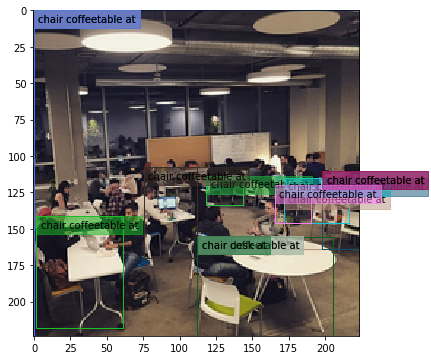

19

In [856]:
show_image(imageIDs_trainz[i], trainz_matched_bbox_list[i], trainz_relationship_list_joined[i])
len(trainz_matched_bbox_list[i])

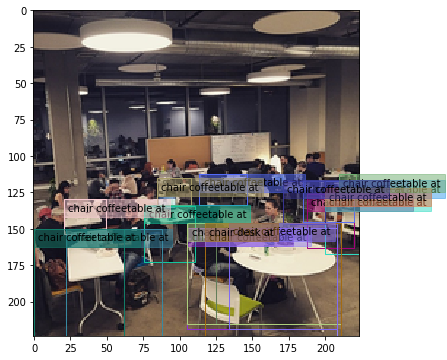

19

In [857]:
show_image(imageIDs_trainz[i], trainz_bbox_list[i], trainz_relationship_list_joined[i])
len(trainz_bbox_list[i])

12753
detected:152, real:6
unique real:6
0.9157567315817527 ((0.58166933, 0.7957797, 0.2072416, 0.47064322), array([0.654375, 0.778125, 0.21    , 0.46    ]))


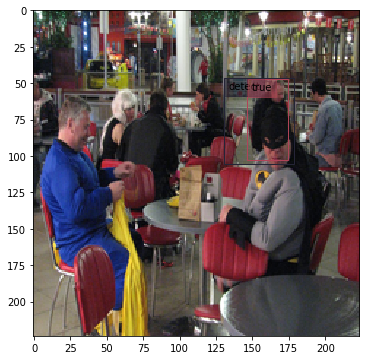

0.9531846116247502 ((0.8233294, 0.9837123, 0.19776705, 0.6497144), array([0.833125  , 0.9775    , 0.21333334, 0.6166667 ]))


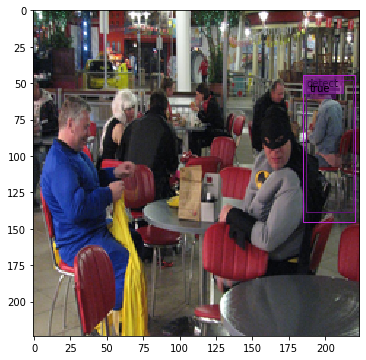

0.8824315762054361 ((0.20537072, 0.45628867, 0.23986344, 0.61269045), array([0.20625   , 0.448125  , 0.24333334, 0.7816667 ]))


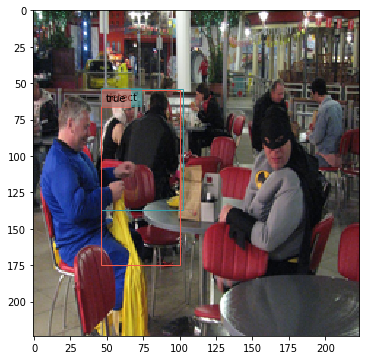

0.9435621791918004 ((0.8233294, 0.9837123, 0.19776705, 0.6497144), array([0.833125  , 0.9775    , 0.21333334, 0.6025    ]))


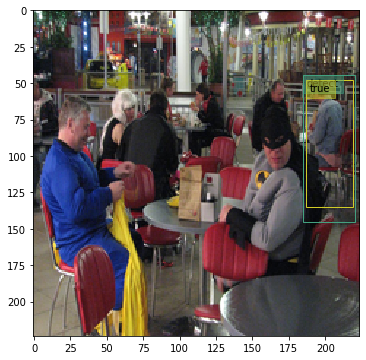

0.9533910793168858 ((0.02011403, 0.33659148, 0.24229082, 0.9875835), array([0.01625   , 0.29875   , 0.25833333, 0.99916667]))


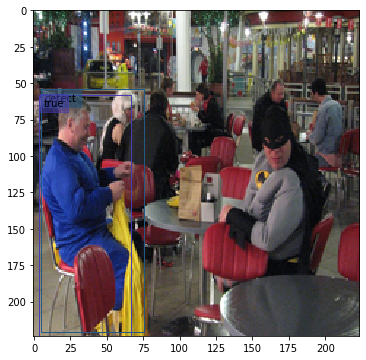

0.8875850282535102 ((0.49205923, 0.9123632, 0.2894797, 0.9205251), array([0.558125  , 0.919375  , 0.28833333, 0.81583333]))


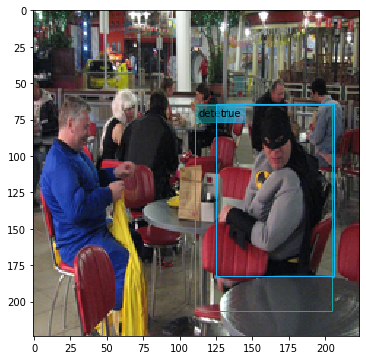

got: 153


In [783]:
from random import randrange
i = randrange(57187)
# i = random.choice(zero)
print(i)
print(f"detected:{len(set(rel_dbboxess[i]))}, real:{len(trainz_bbox_list[i])}")
print(f"unique real:{len(set([str(bs) for bs in trainz_bbox_list[i]]))}")
for j in range(len(trainz_bbox_list[i])):
    b = {} #
    for dbox in set(rel_dbboxess[i]):
    #     print(f"{compute_iou(box, trainz_bbox_list[i][1])}: {box}, {trainz_bbox_list[i][1]}")
        b[compute_iou(dbox, trainz_bbox_list[i][j])] = dbox, trainz_bbox_list[i][j]
    b[-1] = [1,1,1,1], trainz_bbox_list[i][j]
    twoboxes = b[max(b.keys())]
    print(max(b.keys()), b[max(b.keys())])
    show_image(imageIDs_trainz[i], twoboxes, ['detect', 'true'])
print(f"got: {len(b.keys())}")

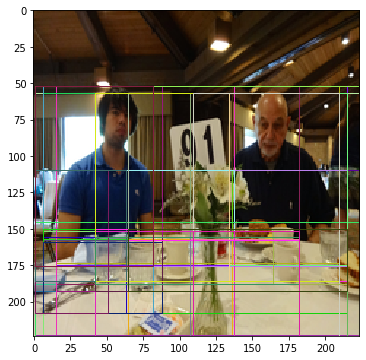

In [705]:
i = 42025
show_image(imageIDs_trainz[i], set(rel_dbboxess[i]))

In [681]:
trainz_bbox_list[i]

array([[0.31537598, 0.87991023, 0.4275    , 0.649375  ],
       [0.04264871, 0.43546578, 0.4275    , 0.598125  ],
       [0.0325477 , 0.43546578, 0.4275    , 0.600625  ]])

***

In [120]:
def show_image(iid, boxes=[], rels=None):
    # Path for the image-file.
    image_path = os.path.join(IMAGE_DIR_REL, (iid + '.jpg'))
    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    plt.rcParams["figure.figsize"] = (18,6)
    import matplotlib.patches as patches
    from matplotlib.offsetbox import AnchoredText
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # xx, yy
    if len(boxes)!=0:
        for i, box in enumerate(boxes):
            boxd = img_size[0]*box[0], img_size[0]*box[1], img_size[1]*box[2], img_size[1]*box[3]
#             print(boxd)
            x1, x2, y1, y2 = boxd
            if (x2, y2) == img_size:
                print("full image")
            col = np.random.rand(3,)
            rect = patches.Rectangle((x1, y1),(x2-x1),(y2-y1),linewidth=1,ec=col,fc='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            if rels:
                ax.text(x1+3, y1+8, rels[i], bbox=dict(ec=col, fc=col, linewidth=-1, alpha=0.5))
    # Plot the image.
    plt.show()

In [501]:
i = 625

In [503]:
tran_dbboxess[i]

[(0.4871487, 0.83689755, 0.3046465, 0.84309375),
 (0.01497941, 0.28295612, 0.00460261, 0.52164686),
 (0.07295445, 0.96931505, 0.5998539, 0.98720074),
 (0.7903647, 0.98760444, 0.44821346, 0.8963629),
 (0.09913337, 0.9563904, 0.6387117, 0.99395955)]

(109.1213088, 187.4650512, 68.240816, 188.853)
(3.35538784, 63.38217088, 1.03098464, 116.84889664)
(16.3417968, 217.1265712, 134.3672736, 221.13296576)
(177.04169280000002, 221.22339456, 100.39981504000001, 200.7852896)
(22.20587488, 214.2314496, 143.0714208, 222.64693920000002)


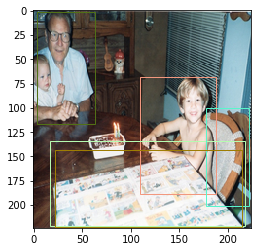

In [505]:
show_image(imageIDs_trainz[i], tran_dbboxess[i])

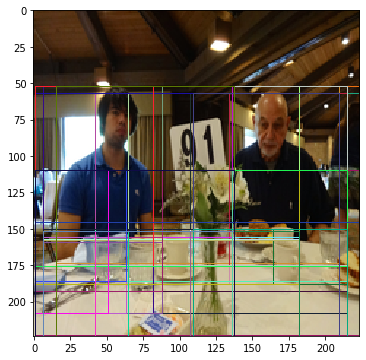

In [704]:
show_image(imageIDs_trainz[i], rel_dbboxess[i])

(3.71527296, 206.35245120000002, 5.798657759999999, 224.0)
(8.514166752, 206.35245120000002, 67.00671487999999, 224.0)
(0.0, 206.35245120000002, 44.45637504, 224.0)


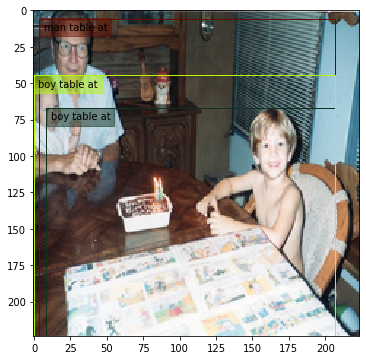

In [563]:
show_image(imageIDs_trainz[i], trainz_bbox_list[i], trainz_relationship_list_joined[i])

In [404]:
iid = imageIDs_trainz[i]
trainz_relationships.iloc[np.where(trainz_relationships.ImageID == iid)[0]]

In [175]:
dbboxess = [parse_boxes(line) for line in open(r"D:\Downloads\models-master\research\object_detection\liny.txt", 'r')]

In [378]:
dbboxess[244]
trainz_bbox_list[244]

array([[0.100625  , 0.87      , 0.7125    , 0.99916667],
       [0.100625  , 0.87      , 0.74083334, 0.99916667],
       [0.100625  , 0.87      , 0.73333335, 0.99916667],
       [0.100625  , 0.87      , 0.69916666, 0.99916667]])

6f36d0be9c2f0887


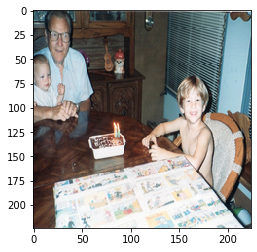

Predicted caption:
 boy table at  

True captions:
['man table at', 'boy table at', 'boy table at']


In [440]:
generate_caption_train((imageIDs_trainz[i]))

In [489]:
%%time
tran_dbboxess = []
zero = []
# (ymin, xmin, ymax, xmax) => x1, x2, y1, y2
for i, dbboxes in enumerate(dbboxess): 
    boxes = []
    for b in dbboxes: 
        try: 
            boxes.append((b[1], b[3], b[0], b[2]))
        except:
            # zero detected boxes
            zero.append(i)
    tran_dbboxess.append(boxes)
        
# tran_dbboxess xxyy
rel_dbboxess = []
for dbboxes in tran_dbboxess:
    rel_dbboxes = []
    for box1 in dbboxes:
        for box2 in dbboxes:
            #if len(bbs1)!=0:
            if str(box1) != str(box2):
                re_box = min(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), max(box1[3], box2[3])
                rel_dbboxes.append(re_box)
    rel_dbboxess.append(rel_dbboxes)

Wall time: 33.2 s


In [328]:
i = 7 # 7 # 9 # 1584 # 625

In [337]:
(trainz_bbox_list[i])

array([[0.        , 0.9710938 , 0.47916666, 0.99895835],
       [0.        , 0.86640626, 0.41875   , 0.99895835],
       [0.        , 0.86640626, 0.1375    , 0.99895835]])

In [336]:
(set(rel_dbboxess[i]))

{(0.14517802, 0.38256705, 0.7823447, 0.7518287),
 (0.4169166, 0.00887012, 0.9252697, 0.314823),
 (0.4836929, 0.6140702, 0.98196816, 0.96708417)}

0e888415ce89126e


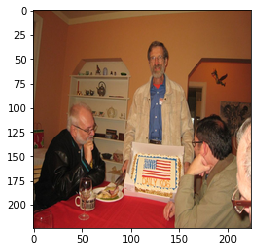

Predicted caption:
 man table at  

True captions:
['man table at', 'man table at', 'man table at']


In [335]:
try:
    generate_caption_train((imageIDs_trainz[i]))
except:
    pass

***

***

***

***

***

***

***

***

***

***

In [173]:
len(imageIDs_trainz)

57187

In [174]:
len(trainz_relationship_list_joined)

51487

In [175]:
51488 - len(imageIDs_trainz) + n_test

1

In [171]:
n_test

5700

***

***

***

***

In [147]:
boxes_lens

[51,
 47,
 22,
 10,
 2,
 23,
 32,
 3,
 8,
 2,
 9,
 4,
 2,
 7,
 40,
 12,
 7,
 9,
 8,
 3,
 14,
 11,
 6,
 6,
 1,
 1,
 16,
 1,
 1,
 11,
 1,
 4,
 15,
 5,
 1,
 2,
 4,
 1,
 11,
 2,
 10,
 22,
 1,
 8,
 14,
 5,
 7,
 1,
 1,
 1,
 21,
 19,
 5,
 11,
 7,
 3,
 9,
 3,
 4,
 1,
 5,
 4,
 4,
 2,
 2,
 7,
 2,
 26,
 5,
 9,
 6,
 2,
 1,
 2,
 4,
 3,
 2,
 4,
 8,
 6,
 3,
 4,
 24,
 1,
 17,
 3,
 7,
 19,
 27,
 7,
 8,
 1,
 8,
 3,
 1,
 26,
 11,
 7,
 1,
 31,
 3,
 2,
 5,
 2,
 27,
 2,
 4,
 1,
 6,
 1,
 8,
 2,
 4,
 2,
 6,
 5,
 4,
 18,
 1,
 1,
 7,
 2,
 2,
 10,
 4,
 4,
 28,
 7,
 9,
 12,
 2,
 2,
 4,
 14,
 4,
 22,
 1,
 2,
 3,
 7,
 2,
 2,
 1,
 29,
 1,
 1,
 8,
 2,
 3,
 2,
 1,
 22,
 6,
 2,
 17,
 1,
 5,
 2,
 1,
 1,
 1,
 1,
 5,
 4,
 2,
 2,
 31,
 6,
 8,
 2,
 10,
 9,
 3,
 2,
 4,
 27,
 2,
 1,
 5,
 2,
 3,
 5,
 3,
 9,
 7,
 7,
 2,
 5,
 1,
 14,
 6,
 4,
 10,
 15,
 6,
 18,
 7,
 11,
 9,
 3,
 8,
 2,
 12,
 49,
 3,
 5,
 8,
 21,
 5,
 5,
 5,
 7,
 4,
 11,
 44,
 11,
 1,
 8,
 3,
 8,
 5,
 21,
 4,
 2,
 4,
 8,
 17,
 6,
 6,
 8,
 14,
 21,
 8,
 2,
 6,
 4,


In [121]:
deindexer[0,50]

NameError: name 'deindexer' is not defined

In [158]:
transfer_values_train[deindexer[iix,0]: deindexer[iix,boxes_lens[iix]-1]]

array([[7.0459e-01, 1.3027e+00, 4.2844e-04, ..., 0.0000e+00, 0.0000e+00,
        1.1365e-01],
       [7.0459e-01, 1.3027e+00, 4.2844e-04, ..., 0.0000e+00, 0.0000e+00,
        1.1365e-01],
       [7.0459e-01, 1.3027e+00, 4.2844e-04, ..., 0.0000e+00, 0.0000e+00,
        1.1365e-01],
       ...,
       [7.0459e-01, 1.3027e+00, 4.2844e-04, ..., 0.0000e+00, 0.0000e+00,
        1.1365e-01],
       [7.0459e-01, 1.3027e+00, 4.2844e-04, ..., 0.0000e+00, 0.0000e+00,
        1.1365e-01],
       [7.0459e-01, 1.3027e+00, 4.2844e-04, ..., 0.0000e+00, 0.0000e+00,
        1.1365e-01]], dtype=float16)

In [166]:
iix = 51487-1
len(transfer_values_train[deindexer[iix,0]: deindexer[iix,boxes_lens[iix]-1]+1])

2

In [252]:
np.reshape(transfer_values, (transfer_values_size,))

array([0.3892 , 0.10034, 1.11   , ..., 0.1954 , 0.1039 , 1.422  ],
      dtype=float16)

In [122]:
def get_caption(image_path, boxes, iix=None, test=False, reload=False, max_tokens=4):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """
    
    if iix and not reload:
        if test:
            reindexer = [(i, j) for i in range(len(testz_matched_bbox_list)) 
                         for j in range(len(testz_matched_bbox_list[i]))]
            deindexer = {(i, j):k for k, (i, j) in enumerate(reindexer)}
#             max_boxes = max([len(bs) for bs in trainz_matched_bbox_list])
            boxes_lens = [len(bs) for bs in testz_matched_bbox_list]
            
            transfer_values_list = transfer_values_test[deindexer[iix,0]:
                                                    deindexer[iix, boxes_lens[iix]-1] +1]
        else:
            reindexer = [(i, j) for i in range(len(trainz_matched_bbox_list)) 
                         for j in range(len(trainz_matched_bbox_list[i]))]
            deindexer = {(i, j):k for k, (i, j) in enumerate(reindexer)}

            boxes_lens = [len(bs) for bs in trainz_matched_bbox_list]
            
            transfer_values_list = transfer_values_train[deindexer[iix,0]:
                                                    deindexer[iix, boxes_lens[iix]-1] +1]
    else:
        #todo
        # Load and resize the image.
        if len(boxes) == 0:
            boxes = [[0,1,0,1]]
        images = load_image_wboxes(image_path, boxes, size=img_size)
        transfer_values_list = []

        for image in images:
            # Expand the 3-dim numpy array to 4-dim
            # because the image-model expects a whole batch as input,
            # so we give it a batch with just one image.
            image_batch = np.expand_dims(image, axis=0)

            # Process the image with the pre-trained image-model
            # to get the transfer-values.
            transfer_values = image_model_transfer.predict(image_batch)
            transfer_values_list.append(transfer_values)
    
    output_predictions = []
    for transfer_values in transfer_values_list:
        transfer_values = np.reshape(transfer_values, (-1, transfer_values_size))
#         print(type(transfer_values))
#         print((transfer_values.shape))
        # Pre-allocate the 2-dim array used as input to the decoder.
        # This holds just a single sequence of integer-tokens,
        # but the decoder-model expects a batch of sequences.
        shape = (1, max_tokens)
        decoder_input_data = np.zeros(shape=shape, dtype=np.int)

        # The first input-token is the special start-token for 'ssss '.
        token_int = token_start

        # Initialize an empty output-text.
        output_text = ''

        # Initialize the number of tokens we have processed.
        count_tokens = 0

        curr_words = 1
        
        output_certainty = []

        # While we haven't sampled the special end-token for ' eeee'
        # and we haven't processed the max number of tokens.

        #while token_int != token_end and count_tokens < max_tokens:
        #while curr_words < max_tokens-2:
        for i in range(max_tokens):
#             print(transfer_values_list)
#             print("in:")
#             print(transfer_values)
            # Update the input-sequence to the decoder
            # with the last token that was sampled.
            # In the first iteration this will set the
            # first element to the start-token.
            decoder_input_data[0, count_tokens] = token_int
            # Wrap the input-data in a dict for clarity and safety,
            # so we are sure we input the data in the right order.
            x_data = \
            {
                'transfer_values_input': transfer_values,
                'decoder_input': decoder_input_data
            }
    
            # Note that we input the entire sequence of tokens
            # to the decoder. This wastes a lot of computation
            # because we are only interested in the last input
            # and output. We could modify the code to return
            # the GRU-states when calling predict() and then
            # feeding these GRU-states as well the next time
            # we call predict(), but it would make the code
            # much more complicated.
            
            # Input this data to the decoder and get the predicted output.
            decoder_output = decoder_model.predict(x_data)
            #print((decoder_output))

            # Get the last predicted token as a one-hot encoded array.
            # Note that this is not limited by softmax, but we just
            # need the index of the largest element so it doesn't matter.
            token_onehot = decoder_output[0, count_tokens, :]
    
            sori = sorted( [(tokenizer.token_to_word(j), w) for j, w in enumerate(token_onehot)] , key=lambda tup:tup[1])
#             print(f"2nd: {sori[-5:]} ")
#             print(f"differenc {sori[-1][1] - sori[-2][1]} ")
#             print(f"2su: {([tup[1] for tup in sori])} ")
            # Convert to an integer-token.
            token_int = np.argmax(token_onehot)
            token_certainty = token_onehot[token_int]

            # Lookup the word corresponding to this integer-token.
            sampled_word = tokenizer.token_to_word(token_int)

            # Append the word to the output-text.
            output_text += " " + sampled_word

            output_certainty.append(token_certainty)
            # Increment the token-counter.
            count_tokens += 1

        # This is the sequence of tokens output by the decoder.
        output_tokens = decoder_input_data[0]
        
        output_predictions.append((output_text, output_certainty))
    # Print the predicted caption.
    return (output_predictions)

In [123]:
def generate_caption_train(iid, test=False, reload=False, matched=True):
    """
    
    """
#     print(iid)

    # Use image and captions from the training-set.
    if test:
        iix = np.where(imageIDs_trainz == iid)[0][0] - len(imageIDs_trainz) + n_test
        true_captions = testz_relationship_list_joined[iix]
#         boxes = testz_matched_bbox_list[iix]
        boxes = testz_matched_bbox_list[iix] if matched else set(rel_dbboxess[np.where(imageIDs_trainz == iid)[0][0]])
    else:
        iix = np.where(imageIDs_trainz == iid)[0][0]
        true_captions = trainz_relationship_list_joined[iix]
        boxes = trainz_matched_bbox_list[iix] if matched else set(rel_dbboxess[iix])
#         print(f"detected boxes: {len(boxes)}")

    # Path for the image-file.
    path = os.path.join(IMAGE_DIR_REL, (iid + '.jpg'))

    # Use the model to generate a caption of the image.
#     predicted_captions = [c.strip() for c in get_caption(path, boxes, iix, test, reload)]
    predicted_captions = get_caption(path, boxes, iix, test, reload)

    #for caption in captions:
    return predicted_captions

In [124]:
def generate_caption_train_show(iid, test=False, reload=False, matched=True):
    """
    
    """
    print(iid)

    # Use image and captions from the training-set.
    if test:
        iix = np.where(imageIDs_trainz == iid)[0][0] - len(imageIDs_trainz) + n_test
        true_captions = testz_relationship_list_joined[iix]
#         boxes = testz_matched_bbox_list[iix]
        boxes = testz_matched_bbox_list[iix] if matched else set(rel_dbboxess[np.where(imageIDs_trainz == iid)[0][0]])
    else:
        iix = np.where(imageIDs_trainz == iid)[0][0]
        true_captions = trainz_relationship_list_joined[iix]
        boxes = trainz_matched_bbox_list[iix] if matched else set(rel_dbboxess[iix])
        print(f"detected boxes: {len(boxes)}")

    # Path for the image-file.
    path = os.path.join(IMAGE_DIR_REL, (iid + '.jpg'))

    # Use the model to generate a caption of the image.
#     predicted_captions = [c.strip() for c in get_caption(path, boxes, iix, test, reload)]
    predicted_captions = get_caption(path, boxes, iix, test, reload)
#     generate_caption(image_path=path)
    show_image(iid, boxes, [r.strip() for r, c in predicted_captions])
    # Print the true captions from the data-set.
    
    print("Predicted captions:")
    #for caption in captions:
#     print((predicted_captions))
    print([r.strip() for r, c in predicted_captions])
#     print(([(r.strip(), round(sum(c)/4, ndigits=1)) for r, c in predicted_captions]))
    print("True captions:")
    #for caption in captions:
    print((true_captions))
    show_image(iid, testz_bbox_list[iix] if test else trainz_bbox_list[iix], true_captions)


In [125]:
def generate_all_predictions(reload=False, matched=True):
    tot = len(imageIDs_trainz)
    end_trai = tot - n_test
    predictions = []
    for i, imageID in enumerate(imageIDs_trainz):
#         if i < 51000:
#             continue
        print_progress(i, tot)
        test = i >= end_trai
        pred = generate_caption_train(imageID, test=test, reload=reload, matched=matched)
        predictions.append(pred)
    return predictions

In [126]:
57187, (51487, 5700), 

(57187, (51487, 5700))

In [127]:
%%time
use_matched_boxes = True
reload_images = False
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"trainz_bb_{'matched' if use_matched_boxes else 'raw'}_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_predictions.pkl")

trainz_predictions = cache(cache_path=cache_path,
                        fn=generate_all_predictions,
                        reload=reload_images, 
                        matched=use_matched_boxes)
len(trainz_predictions)

- Data loaded from cache-file: D:\data\VRNet\trainz_bb_matched_mobilenetv2_1.00_224_9_lstm_predictions.pkl
Wall time: 5.2 s


57187

In [125]:
%%time
use_matched_boxes = True
reload_images = False
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"trainz_bb_{'matched' if use_matched_boxes else 'raw'}_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_predictions.pkl")

trainz_predictions = cache(cache_path=cache_path,
                        fn=generate_all_predictions,
                        reload=reload_images, 
                        matched=use_matched_boxes)
len(trainz_predictions)

- Progress: 100.0% 57186/57187- Data saved to cache-file: D:\data\VRNet\trainz_bb_matched_mobilenetv2_1.00_224_9_lstm_predictions.pkl
Wall time: 7h 10min 17s


57187

In [128]:
sum([len(set(b)) for b in rel_dbboxess]) , sum([len(b) for b in trainz_matched_bbox_list+testz_matched_bbox_list])

(2193251, 180626)

In [129]:
sum([len(set(b)) for b in rel_dbboxess]) / sum([len(b) for b in trainz_matched_bbox_list+testz_matched_bbox_list])

12.142498865058187

In [461]:
trainz_predictions[55683]

[(' chair coffeetable at  ', [14.174137, 16.298891, 17.637852, 20.982098])]

In [130]:
def generate_all_predictions(reload=False, matched=True):
    tot = len(imageIDs_trainz)
    end_trai = tot - n_test
    predictions = []
    for i, imageID in enumerate(imageIDs_trainz):
        if i < 51487:
            continue
        print_progress(i, tot)
        test = i >= end_trai
        pred = generate_caption_train(imageID, test=test, reload=reload, matched=matched)
        predictions.append(pred)
    return predictions

In [131]:
%%time
use_matched_boxes = False
reload_images = True
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"trainz_bb_{'matched' if use_matched_boxes else 'raw'}_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_predictions.pkl")

trainz_predictions = cache(cache_path=cache_path,
                        fn=generate_all_predictions,
                        reload=reload_images, 
                        matched=use_matched_boxes)
len(trainz_predictions)

- Data loaded from cache-file: D:\data\VRNet\trainz_bb_raw_mobilenetv2_1.00_224_9_lstm_predictions.pkl
Wall time: 1.46 s


5700

In [128]:
%%time
use_matched_boxes = False
reload_images = True
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"trainz_bb_{'matched' if use_matched_boxes else 'raw'}_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_predictions.pkl")

trainz_predictions = cache(cache_path=cache_path,
                        fn=generate_all_predictions,
                        reload=reload_images, 
                        matched=use_matched_boxes)
len(trainz_predictions)

- Progress: 100.0% 57186/57187- Data saved to cache-file: D:\data\VRNet\trainz_bb_raw_mobilenetv2_1.00_224_9_lstm_predictions.pkl
Wall time: 4h 1min 48s


5700

In [132]:
testz_relationship_list_joined[5700-1]

['man microphone holds']

In [133]:
len(trainz_predictions)

5700

In [134]:
len(rel_dbboxess)

57187

In [135]:
print(f"Number of train images:\t {len(trainz_bbox_list)}")
print(f"Number of test images:\t {len(testz_bbox_list)}")
print()
print(f"Number of train image boxes:\t\t {len([b for bs in trainz_bbox_list for b in bs])}")
print(f"Number of matched train image boxes:\t {len([b for bs in trainz_matched_bbox_list for b in bs if b!=[0,1,0,1]])}")
print(f"Number of detected train image boxes:\t {len([b for bs in rel_dbboxess[:-n_test] for b in set(bs)])}")
print()
print(f"Number of test image boxes:\t\t {len([b for bs in testz_bbox_list for b in bs])}")
print(f"Number of matched test image boxes:\t {len([b for bs in testz_bbox_list for b in bs if list(b)!=[0,1,0,1]])}")
print(f"Number of detected test image boxes:\t {len([b for bs in rel_dbboxess[-n_test:] for b in set(bs)])}")
print()

print(f"IOU threshold={IOU_THRESHOLD}")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")
print(f"")

Number of train images:	 51487
Number of test images:	 5700

Number of train image boxes:		 174106
Number of matched train image boxes:	 104172
Number of detected train image boxes:	 2081465

Number of test image boxes:		 6520
Number of matched test image boxes:	 6513
Number of detected test image boxes:	 111786

IOU threshold=0.89















Evaluation using [Recall@N](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

`Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)`

Basically, the code for a single image:
```python
true_relations      = ['man deks at', 'man deks at', 'woman guitar plays', 'man glass holds']
predicted_relations = ['man deks at', 'man deks at', 'boy chair on', 'man phone holds', 'girl dog interacts_with']

correct_predictions = 0
for true_relation in true_relations:
    if true_relation is in predicted:
        correct_predictions = correct_predictions+1

2/4 = 50%
...

# Finally, score for all images
score = sum(correct_predictions_list) / true_relation_lists
```

***
```
Number of train images:	51487
Number of test images:	 5700

Number of train image boxes:			 174106
Number of matched train image boxes:	 104172
Number of detected train image boxes:	2081465

Number of test image boxes:			 6520
Number of matched test image boxes:	 6513
Number of detected test image boxes:	111786

IOU threshold=0.89

Number of correct test relations predicted for all images: 
IOU threshold=0.89
Score = 1476 / 6520 = 0.2263

IOU threshold=0.5
Score = 2124 / 6520 = 0.3257

```

In [175]:
2124/6520

0.3257668711656442

In [137]:
len(trainz_predictions), len(testz_relationship_list_joined)

(5700, 5700)

In [139]:
len(rel_dbboxess[-n_test:])

5700

In [177]:
IOU_THRESHOLD = 0.89
IOU_THRESHOLD = 0.5

In [201]:
%%time
iou_eval = {}
for threshold in [round(0.1*p, ndigits=3) for p in range(11)]:
    correct = []
    for i, (relations, boxes) in enumerate(zip(testz_relationship_list_joined, testz_bbox_list)):
    #     print(predictions)
        correct_one = []
        for relation, box in zip(relations, boxes):
            predicted = False
            for (pred_rel, _) , pred_box in zip(trainz_predictions[i], set(rel_dbboxess[-n_test:][i])):
                if len(trainz_predictions[i]) != len(set(rel_dbboxess[-n_test:][i])):
                    print("uh oh stinky")
                    break
                if len(pred_box) == 0:
                    pred_box = [0,1,0,1]
                pred_rel_s= pred_rel.strip().replace('inside of', 'inside_of').replace('interacts with', 'interacts_with')
    #             print(box, pred_box)
                predicted = predicted or (pred_rel_s == relation and compute_iou(box, pred_box) >= threshold)
            correct_one.append(predicted)
    #     pred_rels = [r.strip().replace('inside of', 'inside_of').replace('interacts with', 'interacts_with') for r, c in predictions] 
    #     correct.append([prel in pred_rels for prel in testz_relationship_list_joined[i]])
        correct.append(correct_one)
    iou_eval[threshold] = (sum([rel for rels in correct for rel in rels]) / len(correct)) * 100
len(correct)

Wall time: 3min 4s


5700

In [202]:
iou_eval

{0.0: 37.70175438596491,
 0.1: 37.70175438596491,
 0.2: 37.70175438596491,
 0.3: 37.6140350877193,
 0.4: 37.57894736842105,
 0.5: 37.26315789473684,
 0.6: 36.84210526315789,
 0.7: 35.6140350877193,
 0.8: 32.68421052631579,
 0.9: 25.070175438596493,
 1.0: 0.0}

(0, 39.58684210526316)

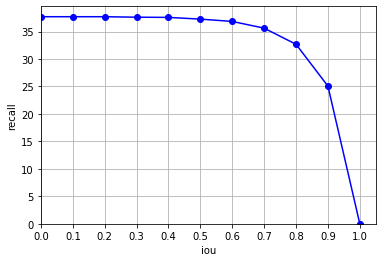

In [203]:
plt.plot(list(iou_eval.keys()), list(iou_eval.values()), 'bo-')
plt.grid()
plt.xlabel('iou')
plt.ylabel('recall')
plt.xticks(list(iou_eval.keys()))
plt.xlim(0)
plt.ylim(0)

In [179]:
sum([rel for rels in correct for rel in rels])

2124

In [195]:
sum([rel for rels in correct for rel in rels])

2711

In [133]:

# testz_relationship_list = trainz_relationship_list[-n_test:]
# trainz_relationship_list = trainz_relationship_list[:-n_test]

test_ids = imageIDs_trainz[-n_test:]
len(test_ids)

5700

In [134]:
test_ids[5]

'13eb81f8086e05e7'

59f821a5a9d76f20


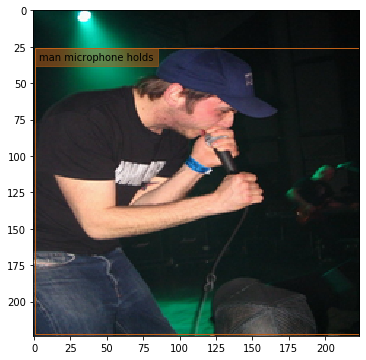

Predicted captions:
['man microphone holds']
True captions:
['man microphone holds']


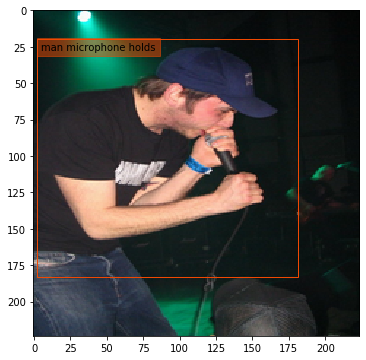

d5bed3779485b60c


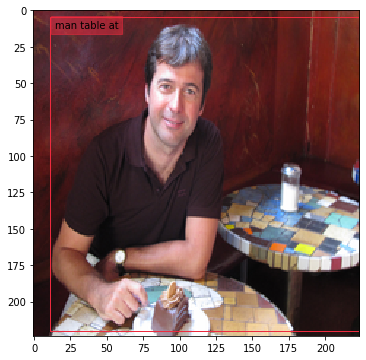

Predicted captions:
['man table at']
True captions:
['man coffeetable at', 'man coffeetable at']


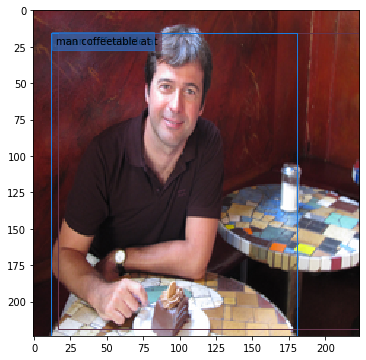

a9c683094aa51de6


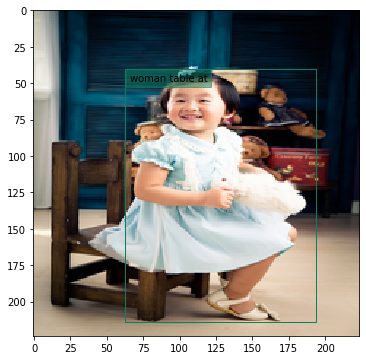

Predicted captions:
['woman table at']
True captions:
['girl chair on']


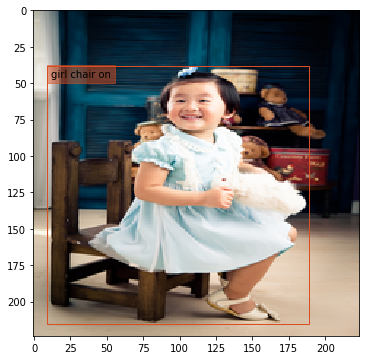

b92d95d6a6ca748c


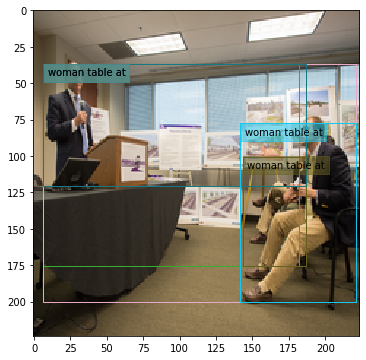

Predicted captions:
['woman table at', 'woman table at', 'woman table at', 'woman table at', 'woman table at']
True captions:
['man desk at', 'chair desk at']


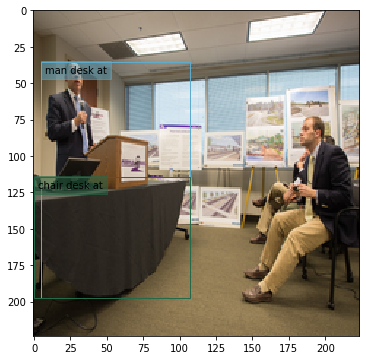

8a4de00f0feb3017


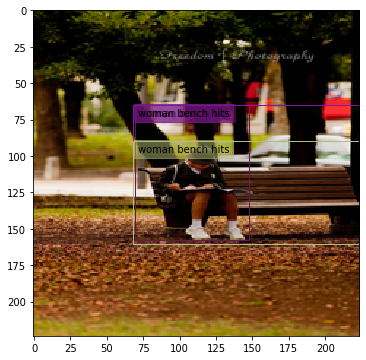

Predicted captions:
['woman bench hits', 'woman bench hits', 'woman bench hits']
True captions:
['boy bench on']


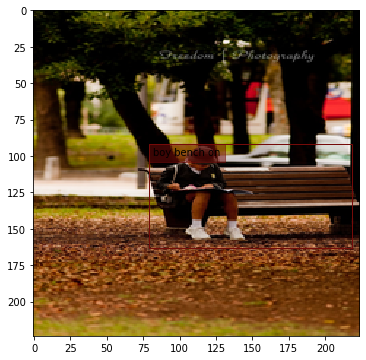

567b883ceaac1a8e


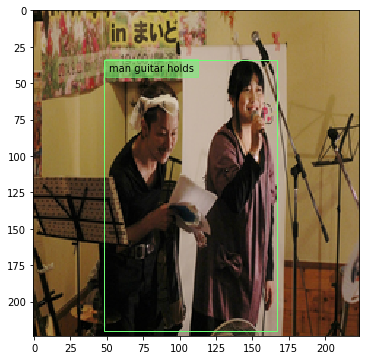

Predicted captions:
['man guitar holds']
True captions:
['woman microphone holds']


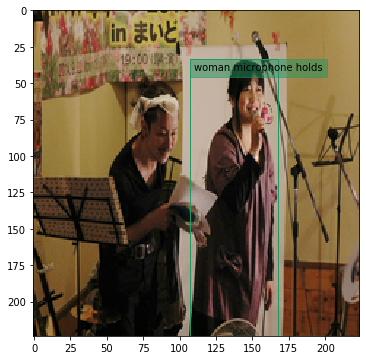

1fbf432b35bf5ce7


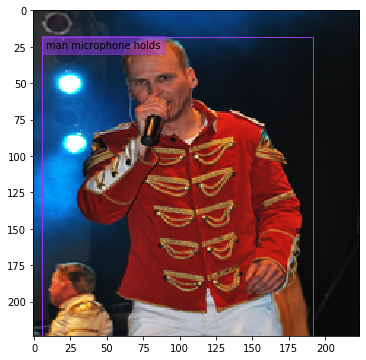

Predicted captions:
['man microphone holds']
True captions:
['man microphone holds']


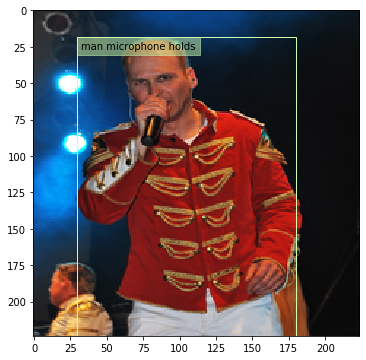

b366021e119e4c74


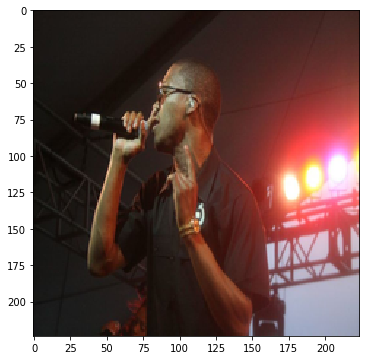

Predicted captions:
['man microphone holds']
True captions:
['man microphone holds']


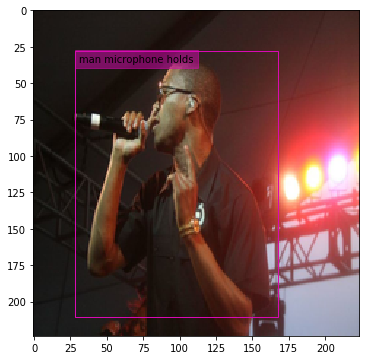

c181ac221a015ede


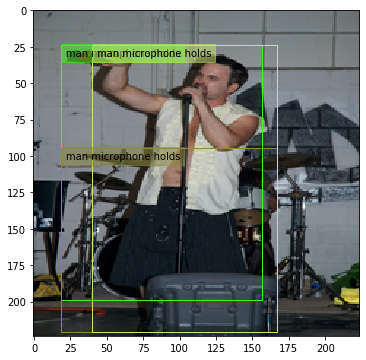

Predicted captions:
['man microphone holds', 'man microphone holds', 'man microphone holds']
True captions:
['man microphone holds']


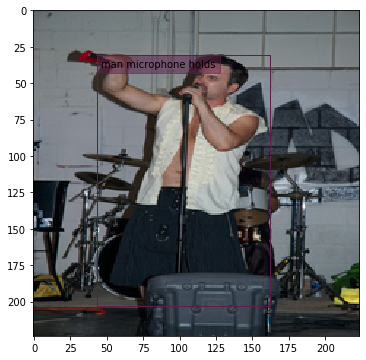

b39f3e86b16b40f9


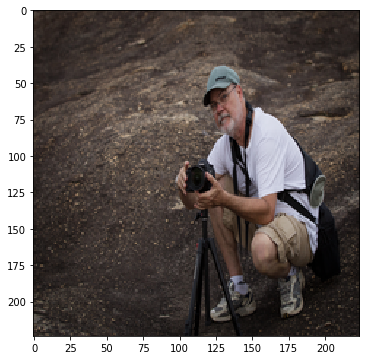

Predicted captions:
['man camera holds']
True captions:
['man camera holds']


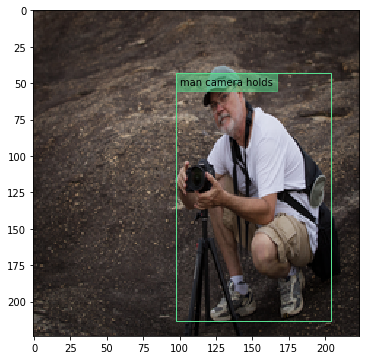

In [211]:
for _ in range(10):
    generate_caption_train_show(np.random.choice(test_ids), test=True, reload=True, matched=False)

In [129]:
trainz_predictions[5]

[(' man microphone holds  ', [8.975378, 14.41204, 10.383292, 18.97545])]

6f36d0be9c2f0887
detected boxes: 3
full image


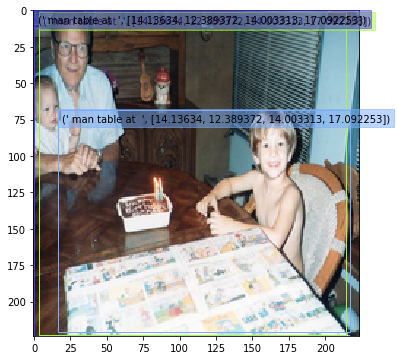

Predicted captions:
[(' man table at  ', [14.13634, 12.389372, 14.003313, 17.092253]), (' man table at  ', [14.13634, 12.389372, 14.003313, 17.092253]), (' man table at  ', [14.13634, 12.389372, 14.003313, 17.092253])]
True captions:
['man table at', 'boy table at', 'boy table at']


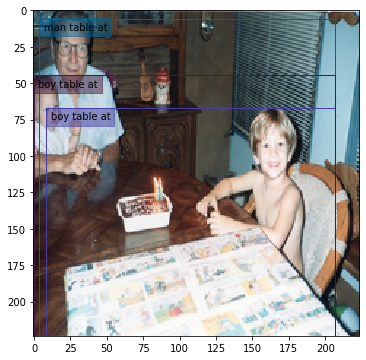

In [439]:
generate_caption_train_show(iid, test=False)

6a77e8b6be088c84
detected boxes: 9
full image
full image
full image


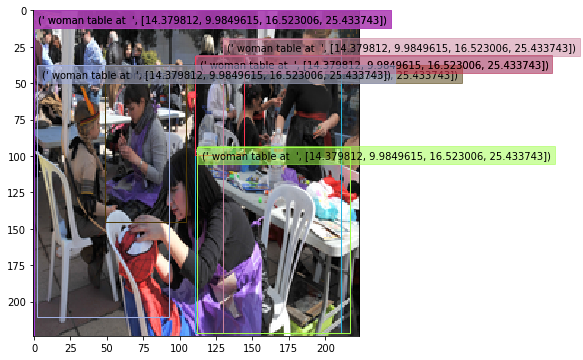

Predicted captions:
[(' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743]), (' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743]), (' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743]), (' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743]), (' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743]), (' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743]), (' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743]), (' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743]), (' woman table at  ', [14.379812, 9.9849615, 16.523006, 25.433743])]
True captions:
['girl table at', 'chair table at', 'man table at', 'girl chair on', 'woman chair on', 'man chair on', 'woman table at', 'chair table at', 'woman chair on']


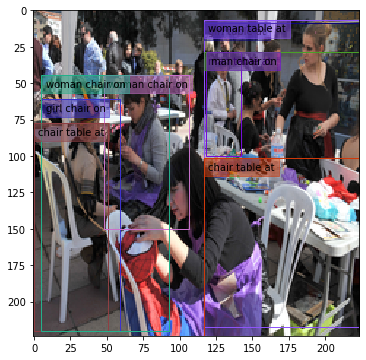

cdba759e8cd37ade
detected boxes: 5
full image
full image
full image


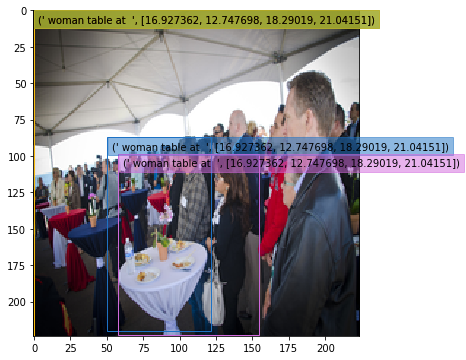

Predicted captions:
[(' woman table at  ', [16.927362, 12.747698, 18.29019, 21.04151]), (' woman table at  ', [16.927362, 12.747698, 18.29019, 21.04151]), (' woman table at  ', [16.927362, 12.747698, 18.29019, 21.04151]), (' woman table at  ', [16.927362, 12.747698, 18.29019, 21.04151]), (' woman table at  ', [16.927362, 12.747698, 18.29019, 21.04151])]
True captions:
['woman table at', 'man table at', 'woman table at', 'woman table at', 'woman table at']


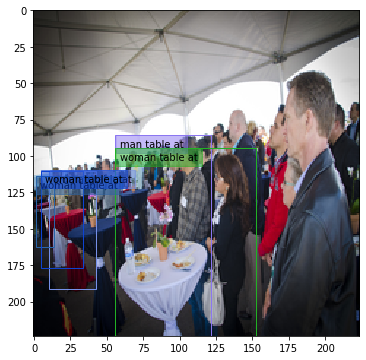

7f9e629834afc10e
detected boxes: 3
full image


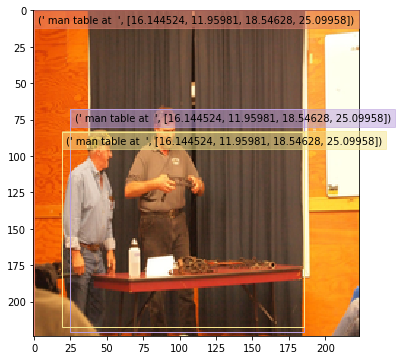

Predicted captions:
[(' man table at  ', [16.144524, 11.95981, 18.54628, 25.09958]), (' man table at  ', [16.144524, 11.95981, 18.54628, 25.09958]), (' man table at  ', [16.144524, 11.95981, 18.54628, 25.09958])]
True captions:
['man table at', 'man table at', 'man table at']


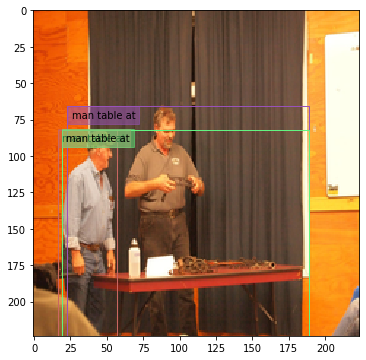

7bb553d2bdc8a64b
8b9e54cee112def7


In [464]:
for _ in range(5):
    try:
        generate_caption_train_show(np.random.choice(imageIDs_trainz), test=False, reload=True)
    except:
        pass

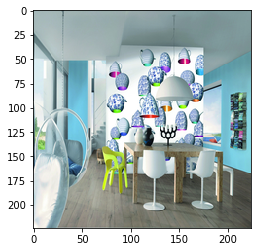

Predicted caption:
 chair table at  



In [109]:
generate_caption(os.path.join(IMAGE_DIR_REL, ('5f07cc69123be854' + '.jpg')))

# Accuracy

In [99]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [100]:
def get_caption_train(image_path, max_tokens=4):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """
    global current
    current = current + 1
    print_progress(current, len(filenames_trainz))
#     # Load and resize the image.
#     image = load_image(image_path, size=img_size)
    
#     # Expand the 3-dim numpy array to 4-dim
#     # because the image-model expects a whole batch as input,
#     # so we give it a batch with just one image.
#     image_batch = np.expand_dims(image, axis=0)

#     # Process the image with the pre-trained image-model
#     # to get the transfer-values.
#     transfer_values = image_model_transfer.predict(image_batch)

    image_id, _ = os.path.splitext(os.path.basename(image_path))
    transfer_values = transfer_values_train[[np.where(imageIDs_trainz == image_id)[0][0]]]
    
    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    curr_words = 1
    
    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    
    #while token_int != token_end and count_tokens < max_tokens:
    #while curr_words < max_tokens-2:
    for i in range(4):
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)
        #print((decoder_output))

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    
    # Print the predicted caption.
    return (output_text)

In [101]:
%%time
global current
current = 0
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"trainz_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_predictions.pkl")
trainz_predictions = cache(cache_path=cache_path,
                        fn=(lambda filenames: [get_caption_train(f).strip() for f in filenames]),
                        filenames=filenames_trainz)
len(trainz_predictions)

- Progress: 100.0% 57187/57187- Data saved to cache-file: D:\data\VRNet\trainz_mobilenetv2_1.00_224_9_lstm_predictions.pkl
Wall time: 1h 36min 16s


57187

In [102]:
len(set(trainz_predictions))

463

In [103]:
%%time
import pickle
precisions = {}
predictions = []

# model_name = get_model_name(params)
# cache_path = os.path.join(DATA_OUTPUT_DIR, os.path.join("predictions", 
#                                                         f"predictions_{get_model_name(params)}.pkl"))

# trainz_predictions = pickle.load(open(cache_path, 'rb'))
# predictions.append(trainz_predictions)
#     print(params)
precision = [prediction in actual 
             for prediction, actual in zip(trainz_predictions, trainz_relationship_list_joined)]
# precisions[model_name] = precision
print(f"{np.sum(precision)}/{len(precision)} {np.sum(precision)/len(precision)} :")

46342/51487 0.9000718628003185 :
Wall time: 48.9 ms


In [143]:
trainz_predictions
len(trainz_relationship_list_joined)

57187

In [137]:
correct = 0
for prediction, actual in zip(trainz_predictions, trainz_relationship_list_joined):
    if prediction in actual:
        correct = correct + 1

correct, len(trainz_relationship_list_joined), correct/len(trainz_relationship_list_joined)

(20292, 57187, 0.35483588927553467)

In [144]:
correct = 0
for prediction, actual in zip(trainz_predictions, trainz_relationship_list_joined):
    if prediction in actual:
        correct = correct + 1

correct, len(trainz_relationship_list_joined), correct/len(trainz_relationship_list_joined)

(21129, 57187, 0.3694720828160246)

***

***

## Donwload images containing relationship data

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [4]:
IMAGE_DIR_REL = r"D:\data\VRNet\imagenet_rel_subset"

In [5]:
def download_image(url, image_name, directory=""):
    import urllib
    import os
    urllib.request.urlretrieve(url, os.path.join(directory, image_name))

def download_images_from_df(dataframe, directory):
    import urllib
    import os
    current_files = os.listdir(directory)
    left_to_dl = dataframe[~dataframe.image_name.isin(current_files)]
    i = len(current_files)
    total = len(dataframe)
    print(f"Downloading {total} images")
    print(f"{i} images already downloaded")
    print(f"Downloading {len(left_to_dl)} remaining")
    
    for index, image_name, image_url in left_to_dl.itertuples():
        i = i + 1 
        print_progress(i, total)
        #if not image_name in current_files:# not os.path.isfile(os.path.join(directory, image_name)):
            #try:
        download_image(image_url, image_name, directory)
            #except: 
            #    pass# print(f"\nError downloading {image_name}")
    print(f"\nDownloaded total {i} images; available total {total}")

In [6]:
import pandas as pd

all_relationships_file = r"D:\data\open-images-2019-visual-relationship\challenge-2019-train-vrd.csv"
all_relationships = pd.read_csv(all_relationships_file)
# all_relationships.describe()
len(all_relationships)

374768

In [7]:
images_w_relationships = all_relationships.ImageID.unique()
len(images_w_relationships)

100522

In [8]:
url_indexes = pd.read_csv(r"D:\data\open-images-2019-visual-relationship\train-images-boxable.csv")
len(url_indexes)

1743042

In [9]:
images_w_relationships_names = [f + '.jpg' for f in images_w_relationships]
url_indexes_relationship = url_indexes[url_indexes.image_name.isin(images_w_relationships_names)]
len(url_indexes_relationship)

100521

In [ ]:
%%time
download_images_from_df(url_indexes_relationship, IMAGE_DIR_REL)

#### Prepare the training images 

In [64]:
filenames_trainz = [os.path.join(IMAGE_DIR_REL, f)
                for f in images_w_relationships_from_dir[:20000]]
len(filenames_trainz)

20000

In [65]:
%%time
transfer_values_train = process_images_train(filenames_trainz, "trainz")
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 20000 images in training-set ...
- Progress: 99.8% 19968/20000
- Data saved to cache-file: D:\data\VRNet\transfer_values_trainz.pkl
dtype: float16
shape: (20000, 4096)
Wall time: 33min 37s


In [61]:
%%time
# Check for faulty images.
removal_list = []
images_w_relationships_from_dir = [os.path.join(IMAGE_DIR_REL, f)
                for f in os.listdir(IMAGE_DIR_REL)]
i = 0
for fn in images_w_relationships_from_dir:
    i = i+1
    print_progress(i, len(images_w_relationships_from_dir))
    try: 
        img = Image.open(fn)
        img.close()
    except:
        removal_list.append(fn)
import pickle
removal_list_file = "to_remove.pkl"
with open(removal_list_file, 'wb') as f:
    pickle.dump(removal_list, f)

- Progress: 100.0% 62090/62090Wall time: 24min 51s


In [70]:
import pickle
with open("to_remove.pkl", 'rb') as f:
    raw = f.read()
removal_list = pickle.loads(raw)
len(removal_list)

80827

In [ ]:
removal_list[10]

In [63]:
for rem in removal_list:
    os.remove(rem)
for rem in removal_list:
    if os.path.isfile(rem):
        print(rem)

\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\


## Pr

In [1]:
import tarfile

tar = tarfile.open(r"D:\data\train-256.tar", "r:gz")


In [4]:
tar.list()

?rwxrwxr-x gsuite/gsuite          0 2019-05-07 05:20:59 train/ 
?rw-rw-r-- gsuite/gsuite      12325 2019-05-05 22:30:18 train/e1f9834934ef3e92.jpg 
?rw-rw-r-- gsuite/gsuite       9486 2019-05-05 22:30:18 train/e7b5158bdc657809.jpg 
?rw-rw-r-- gsuite/gsuite      12880 2019-05-05 22:30:18 train/30b0e36bccf2fd6d.jpg 
?rw-rw-r-- gsuite/gsuite      14792 2019-05-05 22:30:18 train/f75c85626db17a54.jpg 
?rw-rw-r-- gsuite/gsuite      11882 2019-05-05 22:30:18 train/720d4d205bdf190f.JPG 
?rw-rw-r-- gsuite/gsuite      21342 2019-05-05 22:30:18 train/4a187a0145a6400c.jpg 
?rw-rw-r-- gsuite/gsuite       7089 2019-05-05 22:30:18 train/ecb82e2f8b73847d.jpg 
?rw-rw-r-- gsuite/gsuite      14971 2019-05-05 22:30:18 train/1d32395d06e3872f.jpg 
?rw-rw-r-- gsuite/gsuite      12744 2019-05-05 22:30:18 train/bd0ca91b207958ee.jpg 
?rw-rw-r-- gsuite/gsuite       6429 2019-05-05 22:30:18 train/46b78b76a4455dfa.jpg 
?rw-rw-r-- gsuite/gsuite       9527 2019-05-05 22:30:18 train/3531fe9a0c2429da.jpg 
?rw-rw-r-- g

KeyboardInterrupt: 

In [2]:
%%time
tar.extractall(path=r"D:\data\train-256")
tar.close()

Wall time: 1d 23h 23min 38s


In [2]:
%%time
tar.extractall(path=r"D:\data\train-256")
tar.close()

Wall time: 1d 23h 23min 38s


In [2]:
%%time
tar.extractall(path=r"D:\data\train-256")
tar.close()

Wall time: 1d 23h 23min 38s


In [2]:
%%time
tar.extractall(path=r"D:\data\train-256")
tar.close()

Wall time: 1d 23h 23min 38s
